## Image to image translations

In [1]:
#@title Case Study Walkthrough
#@markdown  Image to image translations
from IPython.display import HTML

HTML("""<video width="320" height="240" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_2018_b7_hyd/preview_videos/image_to_image_translation_with_cnn.mp4">
</video>
""")

This experiment is based on the Image-to-Image Translation with Conditional Adversarial Networks.

####Note that this case study based on this [paper.](https://arxiv.org/pdf/1611.07004.pdf)


In [7]:
# ! wget https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz
! sx tar -xvzf facades.tar.gz

/bin/bash: sx: command not found


In [ ]:
ls

facades/        M3W11_CS_29_Image_to_image_translations.ipynb
facades.tar.gz  sample_data/


###Importing required packages


In [ ]:
import torch
import torch.nn as nn
from google.colab import files
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

### Define Discriminator architecture

In [ ]:
def conv_block(in_feat, out_feat, ksize, stride, padding, 
               activation=nn.LeakyReLU(0.2, inplace=True), use_batchnorm=True):
    layers = [nn.Conv2d(in_feat, out_feat, ksize, stride, padding, bias=not use_batchnorm)]
    if use_batchnorm:
        layers.append(nn.BatchNorm2d(out_feat)) 
    if activation:
        layers.append(activation)
    return nn.Sequential(*layers)

class BASIC_D(nn.Module):
    def __init__(self, nc_in, nc_out, ndf, max_layers=3):
        super(BASIC_D, self).__init__()       
        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial{0}-{1}'.format(nc_in+nc_out, ndf),
                        conv_block(nc_in+nc_out, ndf, 4, 2, 1, use_batchnorm=False))
        out_feat = ndf
        for layer in range(1, max_layers):
            in_feat = out_feat
            out_feat = ndf * min(2**layer, 8)
            main.add_module('pyramid{0}-{1}'.format(in_feat, out_feat),
                                conv_block(in_feat, out_feat, 4, 2, 1, ))           
        in_feat = out_feat
        out_feat = ndf*min(2**max_layers, 8)
        main.add_module('last{0}-{1}'.format(in_feat, out_feat),
                        conv_block(in_feat, out_feat, 4, 1, 1))
        
        in_feat, out_feat = out_feat, 1        
        main.add_module('output{0}-{1}'.format(in_feat, out_feat),
                        conv_block(in_feat, out_feat, 4, 1, 1, nn.Sigmoid(), False))
        self.main = main

    def forward(self, a, b):
        x = torch.cat((a, b), 1)        
        output = self.main(x)                    
        return output
    

### Define Generator architecture

In [ ]:
#Define encoder and decoder
class UBlock(nn.Module):
    def __init__(self, s, nf_in, max_nf, use_batchnorm=True, nf_out=None, nf_next=None):
        super(UBlock, self).__init__()
        assert s>=2 and s%2==0
        nf_next = nf_next if nf_next else min(nf_in*2, max_nf)
        nf_out = nf_out if nf_out else nf_in            
        self.conv = nn.Conv2d(nf_in, nf_next, 4, 2, 1, bias=not (use_batchnorm and s>2) )
        if s>2:
            next_block = [nn.BatchNorm2d(nf_next)] if use_batchnorm else []
            next_block += [nn.LeakyReLU(0.2, inplace=True), UBlock(s//2, nf_next, max_nf)]
            self.next_block = nn.Sequential(*next_block)
        else:
            self.next_block = None
        convt = [nn.ReLU(), 
                 nn.ConvTranspose2d(nf_next*2 if self.next_block else nf_next, nf_out,
                                        kernel_size=4, stride=2,padding=1, bias=not use_batchnorm)]    
        if use_batchnorm:
            convt += [nn.BatchNorm2d(nf_out)]        
        if s <= 8:
            convt += [nn.Dropout(0.5, inplace=True)]
        self.convt = nn.Sequential(*convt)  

    def forward(self, x):
        x = self.conv(x)
        if self.next_block:
            x2 = self.next_block(x)
            x = torch.cat((x,x2),1)
        return self.convt(x)        
#U-Net decoder

def UNET_G(isize, nc_in=3, nc_out=3, ngf=64):
    return nn.Sequential(
                  UBlock(isize, nc_in, 8*ngf, False, nf_out=nc_out, nf_next=ngf),
                  nn.Tanh() )

### Weight initialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Set the parameters

In [ ]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
loadSize = 286
imageSize = 256
batchSize = 1
lrD = 2e-4
lrG = 2e-4

### Initialize the discriminator with the defined parameters 

In [ ]:
netD = BASIC_D(nc_in, nc_out, ndf)
netD.apply(weights_init)

BASIC_D(
  (main): Sequential(
    (initial6-64): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (pyramid64-128): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (pyramid128-256): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (last256-512): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slo

### Initialize the Generator with the defined parameters 

In [ ]:
netG = UNET_G(imageSize, nc_in, nc_out, ngf)
netG.apply(weights_init)

Sequential(
  (0): UBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (next_block): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): UBlock(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (next_block): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): UBlock(
            (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (next_block): Sequential(
              (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): LeakyReLU(negative_slope=0.2, inplace=True)
              (2): UBlock(
                (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (next_block): Sequential(
           

### Set the device to CUDA for both discriminator and generator networks

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
netD.to(device)
netG.to(device)

Sequential(
  (0): UBlock(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (next_block): Sequential(
      (0): LeakyReLU(negative_slope=0.2, inplace=True)
      (1): UBlock(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (next_block): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): LeakyReLU(negative_slope=0.2, inplace=True)
          (2): UBlock(
            (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (next_block): Sequential(
              (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): LeakyReLU(negative_slope=0.2, inplace=True)
              (2): UBlock(
                (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
                (next_block): Sequential(
           

### Define functions to load and read the images

In [ ]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)
def read_image(fn, direction=0):
    im = Image.open(fn)
    im = im.resize( (loadSize*2, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    imgA = arr[h1:h2, loadSize+w1:loadSize+w2, :]
    imgB = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        imgA=imgA[:,::-1]
        imgB=imgB[:,::-1]
    if channel_first:
        imgA = np.moveaxis(imgA, 2, 0)
        imgB = np.moveaxis(imgB, 2, 0)
    if direction==0:
        return imgA, imgB
    else:
        return imgB,imgA

### Load the facades train and validation data

In [ ]:
direction = 0
train_path = './facades/train/*.jpg'
val_path = './facades/val/*.jpg'
trainAB = load_data(train_path)
valAB = load_data(val_path)
# Checks if the len(trainAB) and len(valAB) are same if true it continues otherwise it throws an error
assert len(trainAB) and len(valAB)

### Define a function for creating mini batches

In [ ]:
def minibatch(dataAB, batchsize, direction=0):
    length = len(dataAB)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(dataAB)
            i = 0
            epoch+=1        
        dataA = []
        dataB = []
        for j in range(i,i+size):
            imgA,imgB = read_image(dataAB[j], direction)
            dataA.append(imgA)
            dataB.append(imgB)
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        i+=size
        tmpsize = yield epoch, dataA, dataB        

### Define a function to display the image 

In [ ]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

### Visualize the facades and photos in the train data of a mini batch of size 6

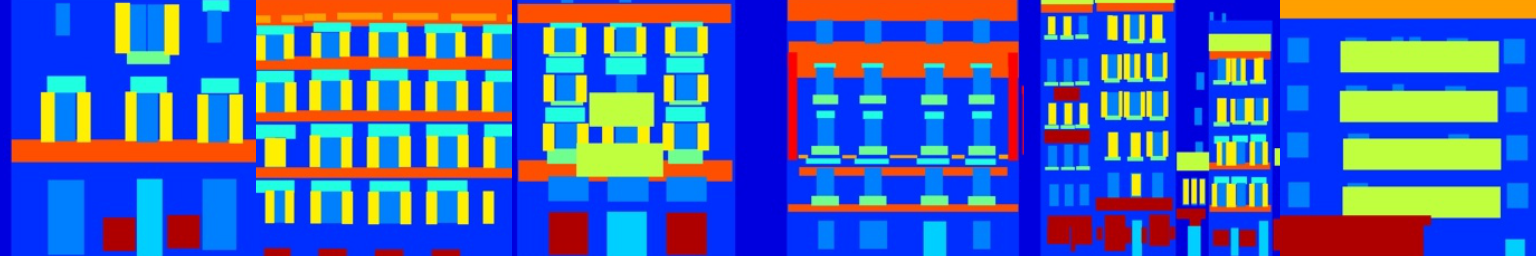

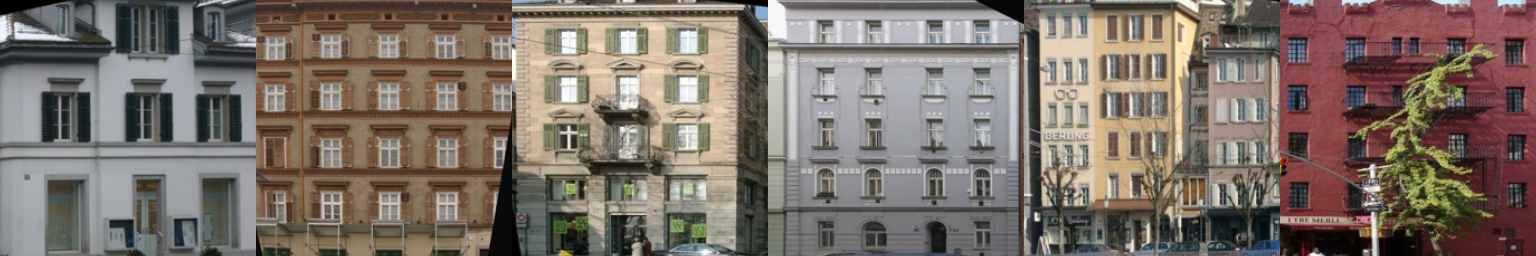

In [ ]:
channel_first=True
train_batch = minibatch(trainAB, 6, direction=direction)
_, trainA, trainB = next(train_batch)
showX(trainA)
showX(trainB)

### Define the optimizers

In [ ]:
optimizerD = optim.Adam(netD.parameters(), lr = lrD, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr = lrG, betas=(0.5, 0.999))

### Define a function for training the discriminator and generator

In [ ]:
loss = nn.BCELoss()
lossL1 = nn.L1Loss()
one = None
zero = None
def netD_train(A, B):    
    global one, zero
    netD.zero_grad()
    output_D_real = netD(A, B)
    if one is None:
        one = Variable(torch.ones(*output_D_real.size()).to(device))
    errD_real = loss(output_D_real, one)
    errD_real.backward()

    output_G = netG(A)
    output_D_fake = netD(A, output_G)
    if zero is None:
        zero = Variable(torch.zeros(*output_D_fake.size()).to(device))
    errD_fake = loss(output_D_fake, zero)
    errD_fake.backward()
    optimizerD.step()
    return (errD_fake.item()+errD_real.item())/2,


def netG_train(A, B):
    global one
    netG.zero_grad()
    output_G = netG(A)
    output_D_fake = netD(A, output_G)
    if one is None:
        one = Variable(torch.ones(*output_D_fake.size()).to(device))
    errG_fake = loss(output_D_fake, one)    
    errG_L1 = lossL1(output_G, B)
    errG = errG_fake + 100 * errG_L1
    errG.backward()
        
    optimizerG.step()
    return errG_fake.item(), errG_L1.item()

In [ ]:
def V(x):
    return Variable(torch.from_numpy(x).to(device))

In [ ]:
def netG_gen(A):
    return np.concatenate([netG(A[i:i+1]).data.cpu().numpy() for i in range(A.size()[0])], axis=0)

In [ ]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 300
gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0
display_iters = 500
val_batch = minibatch(valAB, 6, direction)
train_batch = minibatch(trainAB, batchSize, direction)

###The below code block will take lots of time to run due to training

In [ ]:
while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)   
    vA, vB = V(trainA), V(trainB)
    errD,  = netD_train(vA, vB)
    errD_sum +=errD

    # epoch, trainA, trainB = next(train_batch)
    errG, errL1 = netG_train(vA, vB)
    errG_sum += errG
    errL1_sum += errL1
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        if gen_iterations%(5*display_iters)==0:
            clear_output()
            torch.save(netG.state_dict(), 'pix2pix_facades_Generator_{}_{}.pth'.format(epoch, gen_iterations))
            torch.save(netD.state_dict(), 'pix2pix_facades_Discriminator_{}_{}.pth'.format(epoch, gen_iterations))
        
        print('[%d/%d][%d] Loss_D: %f Loss_G: %f loss_L1: %f'
        % (epoch, niter, gen_iterations, errD_sum/display_iters, 
           errG_sum/display_iters, errL1_sum/display_iters), time.time()-t0)
        _, valA, valB = train_batch.send(6)
        vA, vB = V(valA),V(valB)
        fakeB = netG_gen(vA)
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)
        
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(V(valA))
        showX(np.concatenate([valA, valB, fakeB], axis=0), 3)

###Visualize the output image after training

In [ ]:
for _, trainA, trainB in train_batch:
    fakeB = netG_gen(V(trainA))
    showX(np.concatenate([trainA, trainB, fakeB], axis=0), 3)

In [ ]:
files.download('pix2pix_facades_Generator_{}_{}.pth'.format(epoch, gen_iterations))
files.download('pix2pix_facades_Discriminator_{}_{}.pth'.format(epoch, gen_iterations))
      